In [2]:
%matplotlib inline
%run ../../setup/nb_setup

# Orbits 1: Orbits in Spherical Gravitational Potentials

## Solutions to Exercises

In [3]:
from astropy.constants import G
import astropy.coordinates as coord
import astropy.units as u
from astropy.time import Time

from IPython.display import display, Math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import argrelmax
import sympy as sy

import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

In [4]:
def ptmass_acceleration(xyz, M):
    """
    This function computes the 3D acceleration vector at a
    position or an array of positions "xyz" from a point mass
    with mass "M" at the origin.

    Parameters
    ----------
    xyz : quantity-like
        This should have shape (3, ...)
    M : quantity-like
        The total mass of the point mass.

    """
    r3 = np.sum(xyz ** 2, axis=0) ** (3 / 2)
    dPhi_dx = G * M * xyz / r3
    return -dPhi_dx


def leapfrog_integrate(acc_func, x0, v0, dt, n_steps, acc_func_args=()):
    """
    Parameters
    ----------
    acc_func : callable
        A function that computes the acceleration at a position.
    x0 : quantity-like [length]
        Initial position.
    v0 : quantity-like [velocity]
        Initial velocity.
    dt : quantity-like [time]
        Timestep.
    n_steps : int
        The number of timesteps to take.
    acc_func_args : iterable, list (optional)
        Any additional arguments to be passed to the `acc_func` function.
    """
    # Make sure the input initial conditions and timestep are valid:
    x0 = u.Quantity(x0)
    v0 = u.Quantity(v0)
    ts = u.Quantity(dt) * np.arange(int(n_steps) + 1)

    # Initialize the velocity: step forward by 1/2 timestep
    a0 = acc_func(x0, *acc_func_args)
    v_1_2 = v0 + a0 * dt / 2.0

    # Set up array Quantity objects to store the full orbits for both
    # position and velocity
    xs = np.full((3, len(ts)), np.nan) * x0.unit
    xs[:, 0] = x0
    vs = np.full((3, len(ts)), np.nan) * v0.unit
    vs[:, 0] = v0

    x_im1 = x0
    v_im1_2 = v_1_2
    for i in range(n_steps):
        x_i = x_im1 + v_im1_2 * dt
        a_i = acc_func(x_i, *acc_func_args)

        v_i = v_im1_2 + a_i * dt / 2
        v_ip1_2 = v_i + a_i * dt / 2

        xs[:, i + 1] = x_i
        vs[:, i + 1] = v_i

        x_im1 = x_i
        v_im1_2 = v_ip1_2

    return ts, xs, vs

### Exercise: Compute the acceleration on the Moon from the Sun and Earth - which is larger?

*Hint: The Astropy unit `u.Mearth` might be useful!*

*Solution:*

In [5]:
now = Time.now()

In [6]:
earth_pos = coord.get_body("earth", now)
moon_pos = coord.get_body("moon", now)

In [7]:
moon_ecl = moon_pos.transform_to(coord.HeliocentricTrueEcliptic(obstime=now))
moon_xyz_now = moon_ecl.cartesian.xyz
moon_acc_sun = ptmass_acceleration(moon_xyz_now, M=1 * u.Msun)

In [8]:
moon_acc_earth = ptmass_acceleration(
    (moon_pos.cartesian - earth_pos.cartesian).xyz, M=1 * u.Mearth
)

In [9]:
(
    np.linalg.norm(moon_acc_sun).to(u.km / u.s / u.day),
    np.linalg.norm(moon_acc_earth).to(u.km / u.s / u.day),
)

(<Quantity 0.52092645 km / (d s)>, <Quantity 0.24849902 km / (d s)>)

Answer: The acceleration on the Moon from the Sun is larger!

### Exercise: Varying the initial conditions

So far, we have only worked with initial conditions for a circular orbit. Compute a few more orbits using `leapfrog_integrate()`, but with different choices for initial conditions (e.g., try different y velocity values, or try generating random velocity vectors). What do generic orbits look like?

### Exercise: What is the Plummer density distribution?

Using Poisson's equation, the density is related to the Laplacian of the potential such that:

$$
\rho(r) = (4\pi\,G)^{-1} \, \nabla^2 \Phi
$$

Using the spherical expression of the potential, we must take the spherical Laplacian (but the $\partial \phi$ and $\partial \theta$ terms are zero):

$$
\begin{align}
\nabla^2 \Phi(r) &= \frac{1}{r^2} \, \frac{\partial \Phi}{\partial r}\left( r^2 \, \frac{\partial \Phi}{\partial r} \right)\\
&= \frac{1}{r^2} \, \frac{\partial \Phi}{\partial r}\left( \frac{G\,M\,r^3}{(r^2 + b^2)^{3/2}} \right)\\
\rho(r) &= \frac{M}{\frac{4}{3}\pi\,b^3} \, \left(\frac{r^2}{b^2} + 1\right)^{-5/2}
\end{align}
$$

Proof with `sympy`:

In [10]:
_G, _M, _b, _r = sy.symbols("G, M, b, r", real=True, positive=True)

In [11]:
plummer_Phi = -_G * _M / sy.sqrt(_r ** 2 + _b ** 2)
plummer_Phi

-G*M/sqrt(b**2 + r**2)

In [12]:
plummer_d2_Phi = sy.simplify(
    1 / _r ** 2 * sy.diff(_r ** 2 * sy.diff(plummer_Phi, _r), _r)
)

In [13]:
plummer_dens = plummer_d2_Phi / (4 * sy.pi * _G)
plummer_dens

3*M*b**2/(4*pi*(b**2 + r**2)**(5/2))

### Exercise: Implement the Plummer Potential and Compute a Circular Orbit

**First, derive an expression for the mass enclosed in the Plummer model**

*Solution:*

You can either take the derivative of the potential and compute the mass enclosed using the radial derivative of the potential, or compute the integral of the mass density given above. Here, we will use `sympy` to do both. First, using the derivative:

In [14]:
sy.simplify(sy.sqrt(_r * sy.diff(plummer_Phi, _r)))

sqrt(G)*sqrt(M)*r/(b**2 + r**2)**(3/4)

In [15]:
plummer_Menc = sy.integrate(4 * sy.pi * _r ** 2 * plummer_dens, _r)
sy.simplify(sy.sqrt(_G * plummer_Menc / _r))

sqrt(G)*sqrt(M)*r/(b**2 + r**2)**(3/4)

**Next, implement a function to evaluate the circular velocity in the Plummer potential**

*Solution:*

In [16]:
def plummer_vcirc(r, M, b):
    return np.sqrt(G * M) * r / (r ** 2 + b ** 2) ** (3 / 4)

**Now implement an acceleration function for the Plummer model:**

*Solution:* 

First we have to work out the Cartesian gradient of the potential. For the $x$ term, this is equivalent to:

$$
\begin{align}
\frac{\partial\Phi}{\partial r} &= \frac{G\,M\,r}{(r^2 + b^2)^{3/2}}\\
\frac{\partial\Phi}{\partial x} &= \frac{\partial\Phi}{\partial r} \, \frac{\partial r}{\partial x}\\
&= \frac{\partial\Phi}{\partial r} \, \frac{x}{r}\\
&= \frac{G\,M\,x}{(r^2 + b^2)^{3/2}}
\end{align}
$$

so the $y$ and $z$ terms will be the same, with $x$ swapped out for each respective coordinate value.

In [17]:
def plummer_acceleration(xyz, M, b):
    """
    Parameters
    ----------
    xyz : quantity-like
        This should have shape (3, ...)
    M : quantity-like
        The total mass.
    b : quantity-like
        The scale radius.

    """
    r2 = np.sum(xyz ** 2, axis=0)
    dPhi_dr = G * M / (r2 + b ** 2) ** 1.5
    return -dPhi_dr * xyz

**Finally, compute a circular orbit starting at $(x, y, z) = (5, 0, 0)~\textrm{pc}$ (i.e. $r_0 = 5~\textrm{pc}$) using `leapfrog_integrate()` with the Plummer acceleration function you implemented, adopting the parameter values** $M=10^7~\textrm{M}_\odot$ and $b = 8~\textrm{pc}$

Think about what a good order of magnitude would be for the timestep (*Hint: what is $2\pi\,r_0 / v_\textrm{circ}$?*\)

In [18]:
r0 = 5 * u.pc
x0 = [1, 0, 0] * r0

plummer_M = 1e7 * u.Msun
plummer_b = 8 * u.pc
vcirc = plummer_vcirc(r0, plummer_M, plummer_b)
print(vcirc.to(u.km / u.s))

v0 = [0, 1, 0] * vcirc

35.78557862000943 km / s


In [19]:
dt = 2 * np.pi * r0 / vcirc / 256  # 256 steps per orbital period
dt.to(u.Myr)

<Quantity 0.00335311 Myr>

In [20]:
plummer_ts, plummer_xs, plummer_vs = leapfrog_integrate(
    plummer_acceleration,
    x0=x0,
    v0=v0,
    dt=dt,
    n_steps=1024,
    acc_func_args=(plummer_M, plummer_b),
)

**Plot the orbit in x-y and x-z projections:**

Text(0.5, 0.98, 'Circular orbit in the Plummer model')

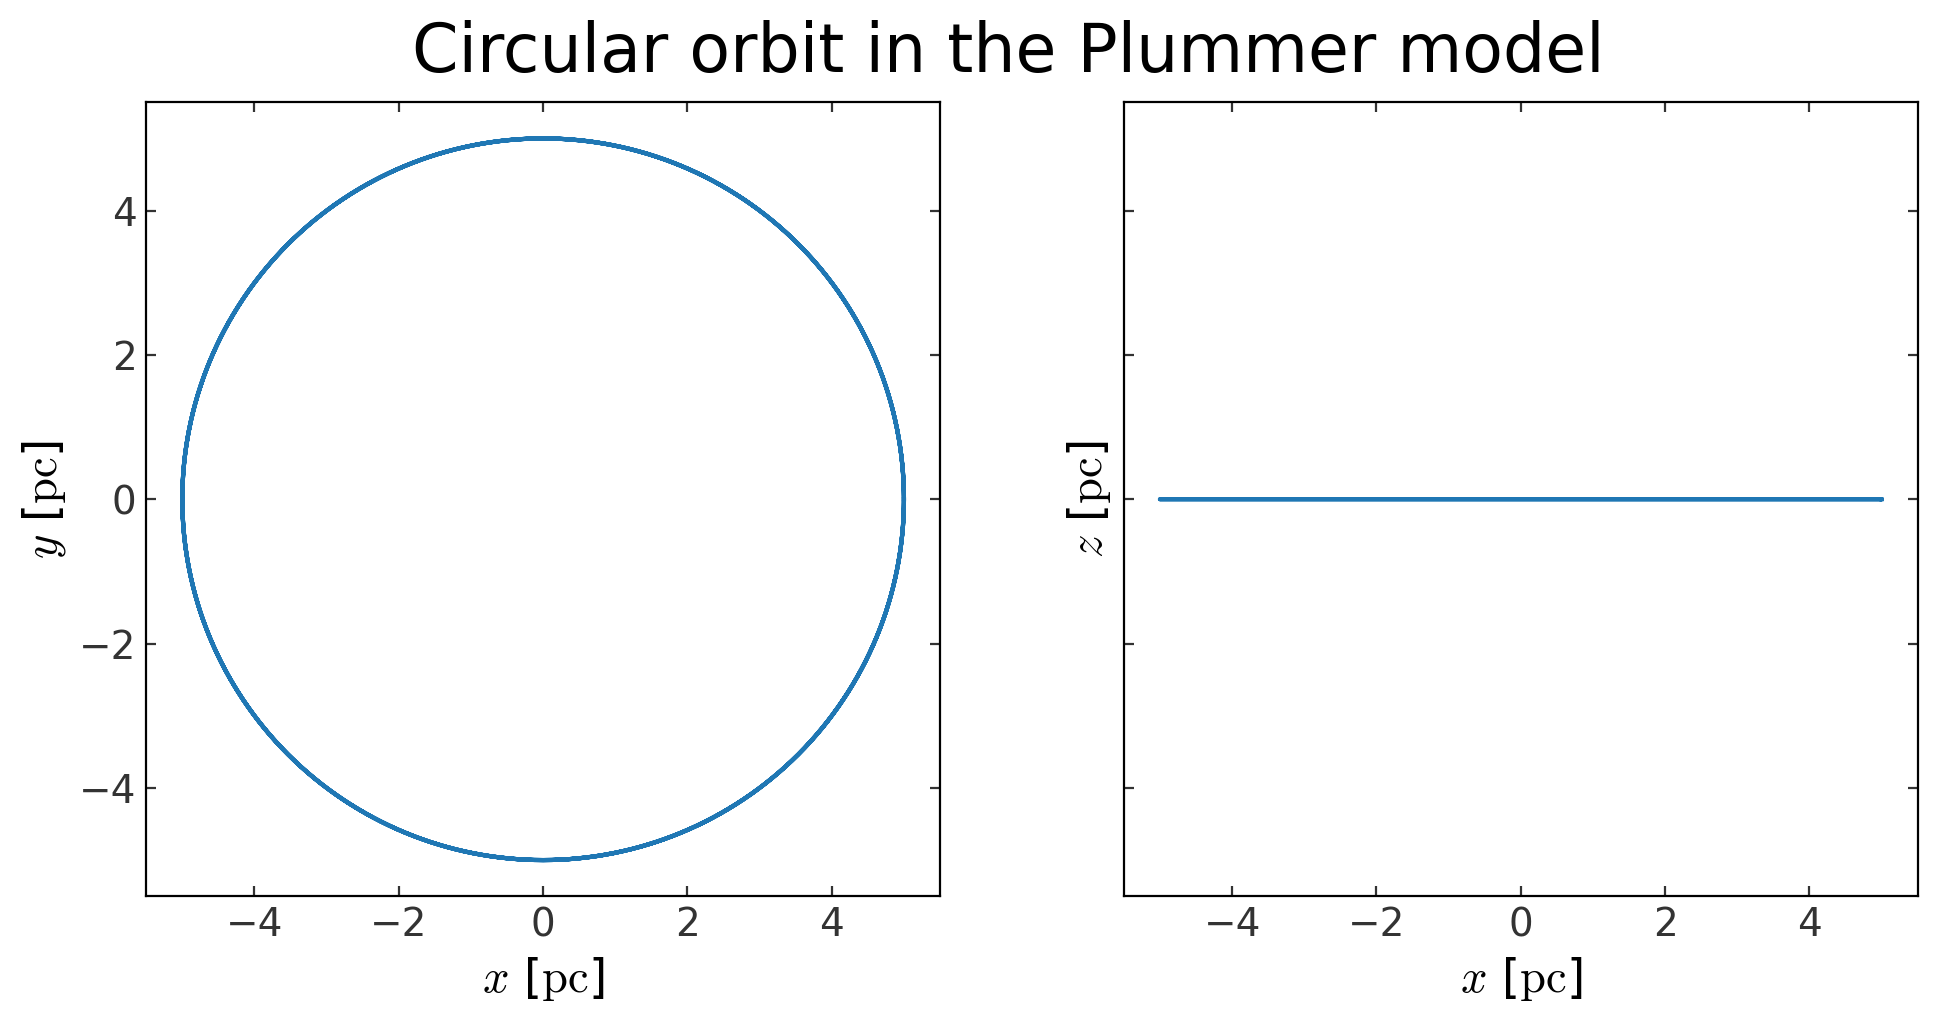

In [21]:
fig, axes = plt.subplots(
    1, 2, figsize=(10, 5), sharex=True, sharey=True, constrained_layout=True
)

# x-y
axes[0].plot(plummer_xs[0], plummer_xs[1])
axes[0].set_xlabel(f"$x$ [{plummer_xs.unit:latex_inline}]")
axes[0].set_ylabel(f"$y$ [{plummer_xs.unit:latex_inline}]")

# x-z
axes[1].plot(plummer_xs[0], plummer_xs[2])
axes[1].set_xlabel(f"$x$ [{plummer_xs.unit:latex_inline}]")
axes[1].set_ylabel(f"$z$ [{plummer_xs.unit:latex_inline}]")

for ax in axes:
    ax.set_aspect("equal")

fig.suptitle("Circular orbit in the Plummer model", fontsize=24)

Compute a few other random bound orbits in the Plummer model (using small, random velocity offsets from the circular orbit initial conditions). Plot these orbits in x-y and x-z projections. How are these orbits different from the orbits in the point mass potential?

In [ ]:
rng = np.random.default_rng(seed=42)

fig, axes = plt.subplots(
    1, 2, figsize=(10, 5), sharex=True, sharey=True, constrained_layout=True
)

axes[0].set_xlabel(f"$x$ [{plummer_xs.unit:latex_inline}]")
axes[0].set_ylabel(f"$y$ [{plummer_xs.unit:latex_inline}]")

axes[1].set_xlabel(f"$x$ [{plummer_xs.unit:latex_inline}]")
axes[1].set_ylabel(f"$z$ [{plummer_xs.unit:latex_inline}]")

for n in range(4):
    this_plummer_ts, this_plummer_xs, this_plummer_vs = leapfrog_integrate(
        plummer_acceleration,
        x0=x0,
        v0=v0 + rng.normal(0, 10, size=3) * u.km / u.s,
        dt=dt,
        n_steps=1024,
        acc_func_args=(plummer_M, plummer_b),
    )

    axes[0].plot(this_plummer_xs[0], this_plummer_xs[1], marker="")
    axes[1].plot(this_plummer_xs[0], this_plummer_xs[2], marker="")

Generic orbits in the Plummer model (and any extended spherical mass distribution) are unlike orbits in the point mass potential: In the point mass model, orbits form closed (Keplerian) ellipses, whereas in generic spherical mass models, orbits are *not* closed and instead trace our "rosette" patterns. One property that all orbits in spherical mass models share (including orbits in the point mass model, Plummer model, and any other) is that they are confined to a plane. That plane can be oriented with any arbitrary angles with respect to the adopted coordinate system, but a fundamental property of orbits in spherical mass models is that the motion can be reduced to 2D planar motion with a suitable choice of coordinate system. This is *not* true in more complex mass models (e.g., axisymmetric/disky, triaxial models, or more realistic models of dark matter distributions in galaxies); so why is this the case in spherical models?

### Exercise: Why do orbits in the point mass potential not fill a 2D space, but instead trace out a 1D curve? 

I.e. can you guess how many isolating integrals of motion there are for orbits in a point mass potential?

*Answer*: 

5! For orbits to be restricted to a line (a 1D curve, and not a 2D plane), there must be one additional isolating integral of motion relative to generic orbits in spherical mass models.

### Exercise: Compute the energy of the DOP853 orbit at all timesteps

*Hint: there is a useful method on `Orbit` objects for doing this!*

In [ ]:
plummer_pot = gp.PlummerPotential(m=plummer_M, b=plummer_b, units=galactic)

In [ ]:
rand_x0 = rng.normal(0, 5, size=3) * u.pc
rand_v0 = rng.normal(0, 20, size=3) * u.km / u.s
w0 = gd.PhaseSpacePosition(pos=rand_x0, vel=rand_v0)

In [ ]:
gala_plummer_orbit_dop853 = plummer_pot.integrate_orbit(
    w0, dt=dt, n_steps=1_000, Integrator=gi.DOPRI853Integrator
)

In [ ]:
plummer_dop853_E = gala_plummer_orbit_dop853.energy()